In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import label
import pandas as pd
from collections import defaultdict
import re
import random

3. MODELO DE ISING CON METRÓPOLIS-HASTINGS

(con el primer bono incluido)

MovieWriter imagemagick unavailable; using Pillow instead.


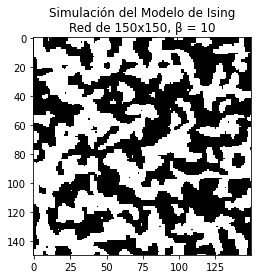

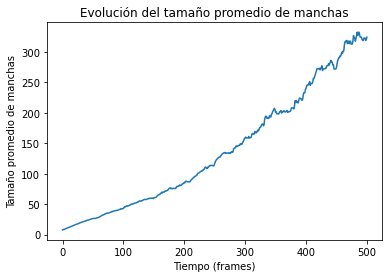

In [13]:
N = 150 
J = 0.2
beta = 10
frames = 500
it = 400

def iniciar_sist(N):
    sistema = np.random.choice([-1, 1], size=(N, N))
    return sistema

sistema = iniciar_sist(N)

def energia_punto(sistema, i, j, N):
    vecinos = [(i + 1) % N, (i - 1) % N, (j + 1) % N, (j - 1) % N]
    energia = -J * sistema[i, j] * (sistema[vecinos[0], j] + sistema[vecinos[1], j] + sistema[i, vecinos[2]] + sistema[i, vecinos[3]])
    return energia

def actualizar_sist(N, beta):
    global sistema
    x, y = np.random.randint(0, N, size=2)
    
    nuevo_sistema = sistema.copy()
    nuevo_sistema[x, y] *= -1

    E_anterior = sum(energia_punto(sistema, x, y, N) for _ in range(5))
    E_nueva = sum(energia_punto(nuevo_sistema, x, y, N) for _ in range(5))

    delta_energia = E_nueva - E_anterior

    if delta_energia <= 0 or np.random.rand() < np.exp(-delta_energia * beta):
        sistema = nuevo_sistema

    return sistema

def tamaño_promedio_manchas(sistema):
    labeled_plus, num_plus = label(sistema == 1)
    labeled_minus, num_minus = label(sistema == -1)
    
    tamaños_plus = [np.sum(labeled_plus == i) for i in range(1, num_plus + 1)]
    tamaños_minus = [np.sum(labeled_minus == i) for i in range(1, num_minus + 1)]
    
    if tamaños_plus and tamaños_minus:
        promedio_plus = np.mean(tamaños_plus)
        promedio_minus = np.mean(tamaños_minus)
        return (promedio_plus + promedio_minus) / 2
    elif tamaños_plus:
        return np.mean(tamaños_plus)
    elif tamaños_minus:
        return np.mean(tamaños_minus)
    else:
        return 0

def actualizar_imagen(frame, imagen, N, beta, it, promedios_tamanos):
    global sistema
    for _ in range(it):
        sistema = actualizar_sist(N, beta)
    
    promedio_tamano = tamaño_promedio_manchas(sistema)
    promedios_tamanos.append(promedio_tamano)
    
    imagen.set_array(sistema)
    return [imagen]

def simular_ising(N, beta, frames, it):
    sistema = iniciar_sist(N)
    
    fig, ax = plt.subplots()
    imagen = ax.imshow(sistema, cmap='gray', interpolation='nearest')
    ax.set_title(f"Simulación del Modelo de Ising\nRed de {N}x{N}, β = {beta}")
    
    promedios_tamaños = [] 
    
    anim = animation.FuncAnimation(fig, actualizar_imagen, frames=frames, fargs=(imagen, N, beta, it, promedios_tamaños), interval=50)
    anim.save('3.Animación ising.gif', writer='imagemagick', fps=10)
    plt.show()
    
    plt.figure()
    plt.plot(range(len(promedios_tamaños)), promedios_tamaños)
    plt.xlabel('Tiempo (frames)')
    plt.ylabel('Tamaño promedio de manchas')
    plt.title('Evolución del tamaño promedio de manchas')
    plt.show()

simular_ising(N, beta, frames, it)

4. GENERACIÓN DE LENGUAJE NATURAL CON CADENAS DE MARKOV

In [14]:
s = "GTCTTAAAAGGCGCGGGTAAGGCCTTGTTCAACACTTGTCCCGTA"

atoms = list("ACGT")
chars = list("ACGT")

F = pd.DataFrame(np.zeros((4, 4), dtype=int), index=atoms, columns=chars)

for i in range(len(s) - 1):
    F.loc[s[i], s[i + 1]] += 1

print("Tabla de frecuencias F:")
print(F,"\n")


P = F / F.sum(axis=1).values[:, None] #Normalización

print("Matriz de probabilidades P: ")
print(P,"\n")

cadena = "ACG"
n_letras = 50

for _ in range(n_letras):
    ultima_letra = cadena[-1]
    nueva_letra = np.random.choice(atoms, p=P.loc[ultima_letra])
    cadena += nueva_letra

print("Cadena generada: ", cadena)

Tabla de frecuencias F:
   A  C  G  T
A  5  2  2  0
C  2  3  3  3
G  0  3  4  5
T  3  3  2  4 

Matriz de probabilidades P: 
          A         C         G         T
A  0.555556  0.222222  0.222222  0.000000
C  0.181818  0.272727  0.272727  0.272727
G  0.000000  0.250000  0.333333  0.416667
T  0.250000  0.250000  0.166667  0.333333 

Cadena generada:  ACGTTAGGCTCTGGCTTCAAAAAACGCCCCAAAAGTCCCTGGCTTAGGTAACT


Libro escogido: Frankenstein

4.1) Limpiar datos

In [15]:
with open('Frankenstein_MS.txt', 'r', encoding='utf-8') as file:
    s = file.read()

def limpiar_texto(s):
    s  = s.replace("\r\n","\n").replace("\n\n","#").replace("\n"," ").replace("#","\n\n")
    s = re.sub(r"[^a-zA-Z\s]", "", s)
    s = re.sub(r"\s+", " ", s)
    s = s.lower() 
    return s

s=limpiar_texto(s)

4.2) Entrenamiento y predicción

In [16]:
def construir_modelo(texto, n):
    modelo = defaultdict(lambda: defaultdict(int))
    
    for i in range(len(texto) - n):
        n_grama = texto[i:i+n]           
        siguiente_caracter = texto[i+n] 
        modelo[n_grama][siguiente_caracter] += 1
    
    return modelo

def convertir_a_dataframe(modelo):
    df = pd.DataFrame.from_dict({k: dict(v) for k, v in modelo.items()}, orient='index').fillna(0)
    return df

n = int(np.random.randint(1, 50, 1))

modelo = construir_modelo(s, n)
df_frecuencias = convertir_a_dataframe(modelo)

def entrenar_ngramas(texto, n=3):
    frecuencias = defaultdict(lambda: defaultdict(int))
    for i in range(len(texto) - n):
        ngrama = texto[i:i+n]
        siguiente_caracter = texto[i+n]
        frecuencias[ngrama][siguiente_caracter] += 1
    
    probabilidades = {}
    for ngrama, siguiente_caracteres in frecuencias.items():
        total = sum(siguiente_caracteres.values())
        probabilidades[ngrama] = {char: count/total for char, count in siguiente_caracteres.items()}
    return probabilidades

modelo_ngramas = entrenar_ngramas(s, n=3)

def generar_texto(modelo, longitud=1500, n=3):
    ngramas_inicio = [ngrama for ngrama in modelo if ngrama.startswith('\n')]
    ngrama_actual = random.choice(ngramas_inicio) if ngramas_inicio else random.choice(list(modelo.keys()))
    
    texto_generado = ngrama_actual
    
    for _ in range(longitud - n):
        siguiente_char = np.random.choice(
            list(modelo[ngrama_actual].keys()), 
            p=list(modelo[ngrama_actual].values())
        )
        texto_generado += siguiente_char
        ngrama_actual = texto_generado[-n:]
    
    return texto_generado

texto_nuevo = generar_texto(modelo_ngramas, longitud=1500)
print(texto_nuevo)
print("Longitud del texto: ", len(texto_nuevo))

i the did at i had lost supplie in and the with speciserval chief world by the dark now she cretchinguisin acquarduous but enote phile had succompation waterdanced barrival emption head could to the founder was spel the madersation which your was it winderous ine but i had atter yound man burn it who fury if signately eyes tim a maded france and i with affic stere her movinction you firecolonged at took one did by him at the to the delations i shed the pers but was montained from the child been secure cling decess wretrange as naturabled melatteral left misdailure usuasily to excell my experatiguestigable had befor escrime to they arand law here hanged portaxed no lone passed none of the morred no quittituation alm cottages me was head impracted of exclamiliar with when were his cour of the submisertal while trave veil dutiful profunct attrayed by moverty the who worden was ques or said nothe dying of opest so effuse open the provided will i comman on i cast a picely to sting tortunabl

4.3) Análisis

In [17]:
n_valores = range(1, 8)
textos_generados = {}

for n in n_valores:
    modelo_ngramas = entrenar_ngramas(s, n=n)
    texto_generado = generar_texto(modelo_ngramas, longitud=1500, n=n)
    textos_generados[n] = texto_generado
    print(f"Texto generado con n = {n}:\n", texto_generado, "\n")

Texto generado con n = 1:
 jutr imeconlupreasalinto aryspepe uthassstind anged ll bure geabe auce pidge s wed y osis inct pr wh tiooucofango me pess th atr an thervecelfray ingh ppanlitre aie thther perd ithathoutitnersiveryofr terofater afrcrse fo authe herd a nd sasstoun can ggrrmo we d on hoem co cesed fo oul ineapo it thendingheppre my fe t ou ifumouar f fa oy reladu ake man thens trndintherisennrneritre t ch but re igesilthent con w toned pladeyoui sam he th wil k ingrye s baryorormy it clere tes d aiviedespurl danermy y l bullf cepesthindsaiofeler r n fag nlesmemutrila atharenst mevean n itise efon orldestevenounam ue ce th towangin t od at th tth t ustor g jun mime ve tinireld test rlly ar ir scr winend y ge canon i f me ne kemea is gan t ar ts oked f s bowa myoomys oure me ofooous ile tiges itaseren tis prs par ancoontullys at ane adoullepinosand ing wamingrereavot avequr wante wn ioredesthinexundi bexchy y ff meand werashi pindichouppongenisthabsin be oliand m her t oshumerin 

In [18]:
with open('words_alpha.txt', 'r') as file:
    palabras_ingles = set(file.read().splitlines())

def porcentaje_palabras_reconocidas(texto, palabras_ingles):
    palabras_generadas = re.findall(r'\b\w+\b', texto)  
    palabras_validas = [palabra for palabra in palabras_generadas if palabra in palabras_ingles]
    return len(palabras_validas) / len(palabras_generadas) * 100 if palabras_generadas else 0

resultados_porcentajes = {}
for n, texto in textos_generados.items():
    porcentaje = porcentaje_palabras_reconocidas(texto, palabras_ingles)
    resultados_porcentajes[n] = porcentaje
    print(f"Porcentaje de palabras en inglés para n = {n}: {porcentaje:.2f}%")

Porcentaje de palabras en inglés para n = 1: 51.64%
Porcentaje de palabras en inglés para n = 2: 55.08%
Porcentaje de palabras en inglés para n = 3: 70.66%
Porcentaje de palabras en inglés para n = 4: 86.92%
Porcentaje de palabras en inglés para n = 5: 98.26%
Porcentaje de palabras en inglés para n = 6: 98.92%
Porcentaje de palabras en inglés para n = 7: 99.64%


Bono 4.3

1) Elección de un libro o género del libro distinto

In [19]:
libros = {"novela": "The Great Gatsby_SF.txt", "poesia": "Poems.txt","ensayo": "Essays.txt"}

textos_generados_por_libro = {}

for genero, archivo in libros.items():
    with open(archivo, 'r', encoding='utf-8') as file:
        texto_libro = file.read()
    
    texto_libro = limpiar_texto(texto_libro)
    
    for n in n_valores:
        modelo_ngramas = entrenar_ngramas(texto_libro, n=n)
        texto_generado = generar_texto(modelo_ngramas, longitud=1500, n=n)
        textos_generados_por_libro[(genero, n)] = texto_generado

resultados_porcentajes_por_libro = {}

for (genero, n), texto in textos_generados_por_libro.items():
    porcentaje = porcentaje_palabras_reconocidas(texto, palabras_ingles)
    resultados_porcentajes_por_libro[(genero, n)] = porcentaje
    print(f"Porcentaje de palabras en inglés para el libro de {genero} con n = {n}: {porcentaje:.2f}%")

Porcentaje de palabras en inglés para el libro de novela con n = 1: 56.46%
Porcentaje de palabras en inglés para el libro de novela con n = 2: 61.11%
Porcentaje de palabras en inglés para el libro de novela con n = 3: 76.17%
Porcentaje de palabras en inglés para el libro de novela con n = 4: 92.76%
Porcentaje de palabras en inglés para el libro de novela con n = 5: 96.44%
Porcentaje de palabras en inglés para el libro de novela con n = 6: 97.56%
Porcentaje de palabras en inglés para el libro de novela con n = 7: 98.60%
Porcentaje de palabras en inglés para el libro de poesia con n = 1: 53.45%
Porcentaje de palabras en inglés para el libro de poesia con n = 2: 62.80%
Porcentaje de palabras en inglés para el libro de poesia con n = 3: 77.85%
Porcentaje de palabras en inglés para el libro de poesia con n = 4: 89.64%
Porcentaje de palabras en inglés para el libro de poesia con n = 5: 97.58%
Porcentaje de palabras en inglés para el libro de poesia con n = 6: 96.80%
Porcentaje de palabras en

A partir de estos resultados nos damos cuenta de que el porcentaje de palabras generadas que, efectivamente, son palabras del inglés no depende ni del libro usado para entenar el modelo ni del género del libro puesto que se utilizó otra novela y líbros de poesía y ensayos.
Esto se evidencia debido a que el porcentaje de palabras en inglés para n=7 es bastante alto (superior al 97%) en los tres casos indistintamente.

2. Elección de un libro en otro idioma

In [20]:
with open('palabras_español.txt', 'r') as file:
    palabras_español = set(file.read().splitlines())

with open('Don Quijote.txt', 'r', encoding='utf-8') as file:
    texto_libro = file.read()

texto_libro = limpiar_texto(texto_libro)

for n in n_valores:
    modelo_ngramas = entrenar_ngramas(texto_libro, n=n)
    texto_generado = generar_texto(modelo_ngramas, longitud=1500, n=n)
    textos_generados[n] = texto_generado

resultados_porcentajes = {}
for n, texto in textos_generados.items():
    porcentaje = porcentaje_palabras_reconocidas(texto, palabras_español)
    resultados_porcentajes[n] = porcentaje
    print(f"Porcentaje de palabras en español para n = {n}: {porcentaje:.2f}%")

Porcentaje de palabras en español para n = 1: 36.33%
Porcentaje de palabras en español para n = 2: 52.19%
Porcentaje de palabras en español para n = 3: 60.82%
Porcentaje de palabras en español para n = 4: 69.07%
Porcentaje de palabras en español para n = 5: 75.17%
Porcentaje de palabras en español para n = 6: 74.73%
Porcentaje de palabras en español para n = 7: 84.88%


Para el caso en el que cambiamos el idioma, nos damos cuenta de que el porcentaje de palabras generadas que, efectivamente, son palabras del español baja significativamente e incluso tiene un comportamiento llamativo puesto que para un mayor valor de n da menos acertado. Esto se puede deber a que el archivo de palabras en español contiene menos palabras que el archivo de palabras en inglés. Pero de manera más importante, hay que tener en cuenta que en español se usa la acentuación (que en inglés no existe) y el código diseñado hace caso omiso a este tipo de caracteres, por lo tanto no es un código apropiado para lenguas en las que se usan acentuaciones como las tildes o letras como la ñ.

3. ¿Qué pasos habría que seguir para que este modelo pudiera mantener una conversación, o producir frases gramaticalmente correctas?

Para responder a esta pregunta se nos ocurre que podríamos aumentar el tamaño de n o usar un contexto más largo. Otra opción, que ya va un poco más allá, sería implementar una red neuronal puesto que es un modelo más avanzado que es capaz de aprender patrones más complejos del lenguaje y mantener información de contextos mucho más largos. Para esto la red tendría que entrenarse con las normas gramaticales (establecer las reglas en el modelo) y con ejemplos de diálogo para que luego pueda replicarlos de manera acertada. 